# Semantic Segmentation

### 1. Indicate the imported packages/libraries

In [2]:
#install the segmentation models pytorch library
! pip install -U segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=4410538e8f05744bec361d49b9208ad5e227a03a069f2b0bbf54b0797ad7195c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a622a9c0264d044e55792afc5410ae60aeb92d89d1e517e3846a173a7eb6f46f
  Stored in directory: /root/.cache/pip/w

In [3]:
# Standard libraries for general purpose programming functionality
import os
import time
import re
import random

# Libraries for handling and processing data
import numpy as np
import pandas as pd
from glob import glob

# Libraries for image processing and augmentation
import cv2
from PIL import Image
from albumentations import HorizontalFlip, Rotate
from torchvision.transforms.functional import to_pil_image

# Libraries for data visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# Libraries for machine learning and data modelling
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import segmentation_models_pytorch as smp

# Libraries for data splitting and model evaluation
from sklearn.model_selection import train_test_split, KFold

### 2. Load the dataset, understand the dataset, and visualize the dataset:


In [4]:
# Mounting google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the path to the text file containing label colors
label_colors_path = '/content/drive/MyDrive/CA3/Cam101/label_colors.txt'

# Define the path to the directory containing training images
train_images_path = '/content/drive/MyDrive/CA3/Cam101/train'

# Define the path to the directory containing testing images
test_images_path = '/content/drive/MyDrive/CA3/Cam101/test'

# Initialize an empty dictionary to store the class-to-color mapping
class_to_color = {}

# Initialize an empty list to store the color palette
palette = []

# Open the label colors file in read mode
with open(label_colors_path, 'r') as f:
    # Read all lines in the file
    lines = f.readlines()
    # Iterate over each line in the file
    for line in lines:
        # Split the line into parts using tab characters
        parts = re.split('\t+', line.strip())
        # Extract the RGB values and convert them to integers
        r, g, b = map(int, parts[0].split(' '))
        # Extract the class name
        class_name = parts[1]
        # Add the class name and corresponding RGB values to the dictionary
        class_to_color[class_name] = (r, g, b)

# Print the class-to-color mapping
print("Class to color mapping:")
# Iterate over the class-to-color dictionary
for class_name, color in class_to_color.items():
    # Print the class name and corresponding RGB values
    print(f"{class_name}: {color}")
    # Add the RGB values to the color palette
    palette.append(list(color))

# Convert the color palette from a list to a numpy array for efficient computation
palette = np.asarray(palette)

# Print the RGB color palette
print(f'\nRGB Palette:\n{palette}')

Class to color mapping:
Animal: (64, 128, 64)
Archway: (192, 0, 128)
Bicyclist: (0, 128, 192)
Bridge: (0, 128, 64)
Building: (128, 0, 0)
Car: (64, 0, 128)
CartLuggagePram: (64, 0, 192)
Child: (192, 128, 64)
Column_Pole: (192, 192, 128)
Fence: (64, 64, 128)
LaneMkgsDriv: (128, 0, 192)
LaneMkgsNonDriv: (192, 0, 64)
Misc_Text: (128, 128, 64)
MotorcycleScooter: (192, 0, 192)
OtherMoving: (128, 64, 64)
ParkingBlock: (64, 192, 128)
Pedestrian: (64, 64, 0)
Road: (128, 64, 128)
RoadShoulder: (128, 128, 192)
Sidewalk: (0, 0, 192)
SignSymbol: (192, 128, 128)
Sky: (128, 128, 128)
SUVPickupTruck: (64, 128, 192)
TrafficCone: (0, 0, 64)
TrafficLight: (0, 64, 64)
Train: (192, 64, 128)
Tree: (128, 128, 0)
Truck_Bus: (192, 128, 192)
Tunnel: (64, 0, 64)
VegetationMisc: (192, 192, 0)
Void: (0, 0, 0)
Wall: (64, 192, 0)

RGB Palette:
[[ 64 128  64]
 [192   0 128]
 [  0 128 192]
 [  0 128  64]
 [128   0   0]
 [ 64   0 128]
 [ 64   0 192]
 [192 128  64]
 [192 192 128]
 [ 64  64 128]
 [128   0 192]
 [192   0 

#### i. Print out the number of training and testing samples in the dataset.

In [6]:
def process_images(images_path):
    """
    Processes images in a specified directory, creates labels for specific images.

    This function looks for .png images in the given directory path and filters out images ending with '_L.png'.
    For the rest of the images, it creates corresponding labels by replacing '.png' with '_L.png' in the image filenames.

    Parameters:
    images_path (str): Path to the directory containing images.

    Returns:
    list: List of image file paths not ending with '_L.png'.
    list: Corresponding labels for the images.
    """
    # Use glob to get all .png files in the specified directory
    images = glob(os.path.join(images_path, '*.png'))

    # Use list comprehension to filter out images ending with '_L.png'
    # For the remaining images, create corresponding labels by replacing '.png' with '_L.png'
    images, labels = zip(*[(img, img.replace('.png', '_L.png')) for img in images if not img.endswith('_L.png')])

    # Convert tuples to lists and return
    return list(images), list(labels)


# Specify the directory paths for training and testing images
train_images_path = '/content/drive/MyDrive/CA3/Cam101/train'
test_images_path = '/content/drive/MyDrive/CA3/Cam101/test'

# Use the process_images function to process both training and testing images
# This will generate lists of images and their corresponding labels
train_images, train_labels = process_images(train_images_path)
test_images, test_labels = process_images(test_images_path)

# Print the number of training and testing samples by getting the length of the lists
print(f"Number of training samples: {len(train_images)}")
print(f"Number of testing samples: {len(test_images)}")


Number of training samples: 90
Number of testing samples: 11


##### a. Defining a function to seed the randomness.

In [7]:
def seeding(seed):
    '''
    Function to set the seed for generating random numbers in Python, numpy, and PyTorch.
    
    Parameters:
    seed (int): The seed value to be set.
    
    This function is used to ensure the reproducibility of results that involve randomness.
    It sets the seed for Python's built-in random module, numpy, and PyTorch.
    It also sets the PYTHONHASHSEED environment variable and enables deterministic mode in PyTorch.
    '''

    # Seed Python's built-in random module to ensure reproducibility in Python-specific operations
    random.seed(seed)

    # Set the PYTHONHASHSEED environment variable to make Python's hash-based operations consistent across runs
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Seed numpy's random number generator to ensure reproducibility in numpy-specific operations
    np.random.seed(seed)

    # Seed PyTorch's random number generator for both CPU and all CUDA devices for reproducibility in PyTorch-specific operations
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # Enable deterministic algorithms for CuDNN. This may slightly slow down the computations,
    # but will ensure the same results for the same inputs in the face of randomness
    torch.backends.cudnn.deterministic = True

# Set the seed for all random number generators to ensure reproducibility
seeding(7)


#### ii. Plot some figures to visualize some samples.


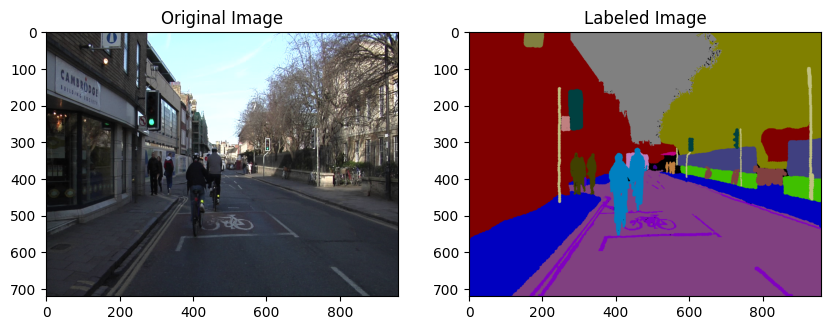

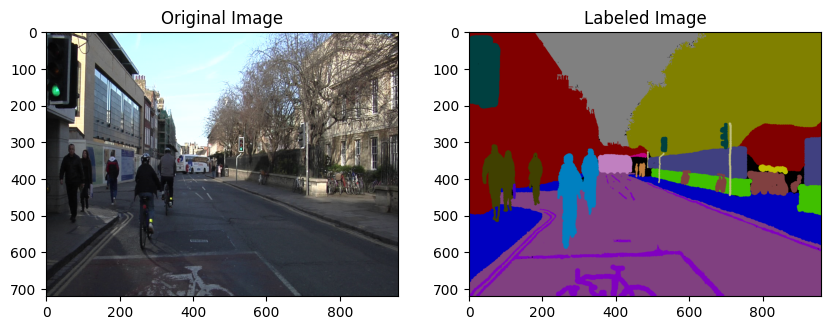

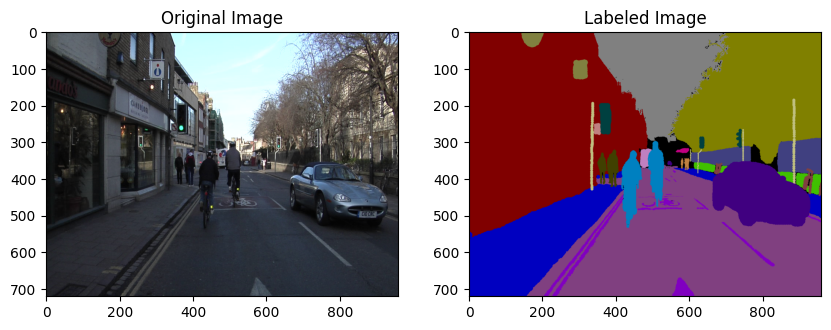

In [8]:
def visualize_sample(image_path, label_path):
    """
    This function reads an image and its corresponding label image, 
    and then displays them side by side.

    Parameters:
    image_path (str): The file path to the image.
    label_path (str): The file path to the corresponding label image.
    """
    
    # Using OpenCV's imread function, read the image from the image_path
    # Then, convert the color scheme from BGR to RGB using cvtColor function 
    # as OpenCV reads images in BGR format
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    
    # Using OpenCV's imread function, read the label image from the label_path
    # The '0' argument indicates that the image is to be loaded in grayscale mode
    label_img = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)
    #label_img = cv2.imread(label_path, 0)
    
    # Create a 1x2 subplot using matplotlib's subplots function for displaying the image and label
    # The figsize argument sets the figure size in inches
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image on the first subplot
    ax[0].imshow(img)
    ax[0].set_title("Original Image")

    # Display the label image on the second subplot
    # The 'gray' colormap is used for the grayscale image
    ax[1].imshow(label_img, cmap='gray')
    ax[1].set_title("Labeled Image")

    # Show the plot using matplotlib's show function
    plt.show()

# Visualize a few samples
for _ in range(3):
    # Select a random index from the training images using numpy's random.randint function
    i = np.random.randint(0, len(train_images))
    
    # Visualize the selected sample by calling the visualize_sample function with the randomly selected image and its corresponding label
    visualize_sample(train_images[i], train_labels[i])


### 3. Pls explore data augmentation techniques to expand the data in the training dataset.


###### a. Creating directories to save the augmented data

In [9]:
def create_dir(path):
    """
    This function takes a path as input and creates a directory at this path 
    if it does not already exist.

    Parameters:
    path (str): The path where the directory needs to be created.

    Returns:
    None
    """
    
    # Check if the directory exists using os.path.exists
    if not os.path.exists(path):
        # If the directory does not exist, create the directory using os.makedirs
        os.makedirs(path)

# List of directories to be created
directories = [
    '/content/drive/MyDrive/CA3/Cam101/AugmentedData/train/image/', 
    '/content/drive/MyDrive/CA3/Cam101/AugmentedData/train/label/', 
    '/content/drive/MyDrive/CA3/Cam101/AugmentedData/test/image/', 
    '/content/drive/MyDrive/CA3/Cam101/AugmentedData/test/label/',
    '/content/drive/MyDrive/CA3/NetworkCheckpoints',
]

# Loop through the list of directories
for dir_path in directories:
    # Call create_dir function for each directory in the list
    create_dir(dir_path)

###### b. Defining a function for augmenting the data

In [10]:
def augment_data(images, labels, save_path, augment=True):
  '''
  This function applies image augmentation - namely HorizontalFlip, VerticalFlip, and Rotate - to the training images and their labels. It also resizes
  both the training and testing images and labels.

  Parameters:
  images (list): A list of file paths to the training images.
  labels (list): A list of file paths to the labels corresponding to the training images.
  save_path (str): The directory where the augmented images and labels will be saved.
  augment (bool): A flag to determine whether to perform data augmentation or not. Defaults to True.
  
  Returns:
  None. The function saves the augmented images and their corresponding labels in the given directory.
  '''

  # Define the new size to which the images will be resized
  new_size = (512, 512) 

  # Iterate over the images and labels
  for i, (x, y) in tqdm(enumerate(zip(images, labels)), total=len(images)):
    # Extract the name of the image from its file path
    x_name = os.path.splitext(os.path.basename(x))[0]
    
    # Read the image and the label using OpenCV
    x = cv2.imread(x, cv2.COLOR_BGR2RGB)
    y = cv2.imread(y, cv2.COLOR_BGR2RGB)

    # If data augmentation is set to True
    if augment == True:
      # Apply a horizontal flip to the image with a probability of 1
      aug = HorizontalFlip(p=1.0) 
      # Send the image and label to be augmented
      augmented = aug(image = x, label = y) 
      # Extract the augmented image and label
      x1 = augmented['image']
      y1 = augmented['label']

      # Apply a rotation at a random angle between 0 and 45 degrees
      aug = Rotate(limit=45, p=1.0)
      augmented = aug(image = x, label = y)
      # Extract the rotated image and label
      x2 = augmented['image']
      y2 = augmented['label']

      # Append the original, horizontally flipped and rotated images and labels to lists X and Y respectively
      X = [x, x1, x2]
      Y = [y, y1, y2]

    else: # If no data augmentation is to be applied
      # Append the original image (x) and label (y) to lists X and Y respectively
      X = [x]
      Y = [y]

    index = 0
    for img, lab in zip(X, Y):
      # Resize the image and label to the new size
      img = cv2.resize(img, new_size)
      lab = cv2.resize(lab, new_size)

      # Construct the file name for the image and label
      temp_image_name = f'{x_name}_{index}.png'
      temp_label_name = f'{x_name}_{index}.png'

      # Construct the file path for the image and label
      image_path = os.path.join(save_path, 'image', temp_image_name)
      label_path = os.path.join(save_path, 'label', temp_label_name)

      # Save the image and label at the respective file paths
      cv2.imwrite(image_path, img)
      cv2.imwrite(label_path, lab)

      index += 1


###### c. Performing data augmentation

In [11]:
# Flag to control whether data has been augmented already
AUGMENTED = False

# If data has not been augmented yet
if AUGMENTED is not True:
    # Apply augmentation to training images and labels
    augment_data(train_images, train_labels, '/content/drive/MyDrive/CA3/Cam101/AugmentedData/train/', augment=True)
    
    # Apply resizing only to test images and labels (no other augmentations)
    augment_data(test_images, test_labels, '/content/drive/MyDrive/CA3/Cam101/AugmentedData/test/', augment=False)

100%|██████████| 11/11 [00:22<00:00,  2.00s/it]


### 4. Split the augmented training dataset into the training set and validation set (90% vs 10%). Build a training, validation, and testing dataset pipeline (like DataLoader in PyTorch)

##### a. Loading the dataset

In [12]:
# Define the directories where the images and labels are stored
train_images_dir = '/content/drive/MyDrive/CA3/Cam101/AugmentedData/train/image/*'
train_labels_dir = '/content/drive/MyDrive/CA3/Cam101/AugmentedData/train/label/*'
test_images_dir = '/content/drive/MyDrive/CA3/Cam101/AugmentedData/test/image/*'
test_labels_dir = '/content/drive/MyDrive/CA3/Cam101/AugmentedData/test/label/*'

# Load the training images and labels
train_x = sorted(glob(train_images_dir))
train_y = sorted(glob(train_labels_dir))
# Split the training data into train (90%) and validation (10%)
train_data_x, valid_data_x, train_data_y, valid_data_y = train_test_split(train_x, train_y, train_size=0.9, random_state=7)

# Load the test images and labels
test_data_x = sorted(glob(test_images_dir))
test_data_y = sorted(glob(test_labels_dir))

# Print the size of each dataset
print(f'Dataset size:\nTrain: {len(train_data_x)} - Validation: {len(valid_data_x)} - Test: {len(test_data_x)}')

Dataset size:
Train: 243 - Validation: 27 - Test: 11


##### b. Creating CustomDataset instances

In [13]:
class CustomDataset(Dataset):
  """
  A custom Dataset class for loading images and their corresponding labels.
  
  Attributes
  ----------
  images_path : list
      List of paths to image files.
  labels_path : list
      List of paths to label files.
  num_samples : int
      Number of samples in the dataset.
  palette : list
      List of RGB colours to be used for relabelling pixels in the label images.
  """
  
  def __init__(self, images_path, labels_path):
    """
    Initializes the CustomDataset object.

    Parameters
    ----------
    images_path : list
        List of paths to image files.
    labels_path : list
        List of paths to label files.
    """
    self.images_path = images_path
    self.labels_path = labels_path
    self.num_samples = len(images_path)
    self.palette = palette

  def __getitem__(self, index):
    """
    Retrieves an image and its corresponding label using an index.
    
    Parameters
    ----------
    index : int
        Index of the image and label to retrieve.
    
    Returns
    -------
    tuple
        A tuple containing the image and its corresponding label (mask).
    """
    # Reading the image at the specified index
    image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
    # Normalizing the image by dividing the pixel values by 255
    image = image/255.0
    # Transposing the image to change from channel last to channel first format
    image = np.transpose(image, (2, 0, 1))
    # Converting the image data type to float32
    image = image.astype(np.float32)
    # Converting the image to a PyTorch tensor
    image = torch.from_numpy(image)
    
    # Reading the label (mask) at the specified index
    label = cv2.imread(self.labels_path[index], cv2.IMREAD_COLOR)
    # Relabelling the label image pixels from RGB values to classes
    mask = []
    for colour in self.palette:
      # Comparing each pixel in the label image with the colour
      cmap = np.all(np.equal(label, colour), axis=-1)
      mask.append(cmap)
    
    # Stacking the masks for each colour into a multi-channel mask
    mask = np.stack(mask, axis=-1)
    # Converting the mask data type to uint8
    mask = mask.astype(np.uint8)
    # Transposing the mask to change from channel last to channel first format
    mask = np.transpose(mask, (2, 0, 1))
    # Converting the mask to a PyTorch tensor
    mask = torch.from_numpy(mask)

    return image, mask
  
  def __len__(self):
    """
    Retrieves the number of samples in the dataset.
    
    Returns
    -------
    int
        The number of samples in the dataset.
    """
    return self.num_samples


In [14]:
# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 8

# Create instances of the CustomDataset using the train, validation, and test data
train_dataset = CustomDataset(train_data_x, train_data_y)
valid_dataset = CustomDataset(valid_data_x, valid_data_y)
test_dataset = CustomDataset(test_data_x, test_data_y)

# Create DataLoader objects for the train, validation, and test datasets
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True, # Shuffle the data
    num_workers = num_workers)

val_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = batch_size,
    shuffle = False, # No need to shuffle the data
    num_workers = num_workers)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False, # No need to shuffle the data
    num_workers = num_workers)

# Get one batch of training data
train_images, train_labels = next(iter(train_loader))

print(f'Images batch shape: {train_images.shape}')
print(f'Mask batch shape: {train_labels.shape}')

Images batch shape: torch.Size([8, 3, 512, 512])
Mask batch shape: torch.Size([8, 32, 512, 512])


##### c. Enabling a hardware accelerator

In [15]:
#use a hardware accelerator (GPU) if available, else use the CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


##### c. Defining helper functions

In [16]:
def calculate_metrics(y_pred, y_true):
  '''
  Calculate the Intersection over Union (IoU) and pixel accuracy between predicted labels and ground truth labels.
  
  Parameters:
  y_pred (tensor): Tensor of predicted labels.
  y_true (tensor): Tensor of ground truth labels.
  
  Returns:
  IoU (float): Intersection over Union (IoU) score.
  accuracy (float): Pixel accuracy score.
  '''
  #send the two tensors to the cpu
  y_pred = y_pred.cpu()
  y_true = y_true.cpu()

  #compute the true positive, false positive, true negative, and false negative 'pixels'
  tp, fp, fn, tn = smp.metrics.get_stats(y_pred, y_true, mode='multilabel', threshold=0.5) #apply a binarization threshold on each feature layer

  #compute the Intersection over Union (IoU) and pixel accuracy
  iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
  accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

  return iou_score, accuracy

def run_time(start_time, end_time):
  '''
  Calculate the elapsed time between two timestamps in minutes and seconds.
  
  Parameters:
  start_time (float): Start timestamp.
  end_time (float): End timestamp.
  
  Returns:
  mins (int): Minutes component of elapsed time.
  secs (int): Seconds component of elapsed time.
  '''
  # Calculate elapsed time in seconds
  time_taken = end_time - start_time
  
  # Calculate minutes and seconds components
  mins = int(time_taken/60)
  secs = int(time_taken - (mins * 60))
  
  return mins, secs

def plot_train(epochs, train_losses, train_IoU_list, train_accuracy_list,
                       val_losses, val_IoU_list, val_accuracy_list):
  '''
  This function plots the training and validation results of a network
  '''
  fig, ax1 = plt.subplots(figsize=(10, 4), layout='constrained')
  fig, ax2 = plt.subplots(figsize=(10, 4), layout='constrained')
  fig, ax3 = plt.subplots(figsize=(10, 4), layout='constrained')

  #plot the train and validation losses vs the number of epochs
  ax1.plot(np.arange(1,epochs+1), train_losses, label='Train', color='green')
  ax1.plot(np.arange(1,epochs+1), val_losses, label='Validation', color='purple')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Average loss')
  ax1.set_title("Average losses vs Epochs")
  ax1.legend()
  #plot the train and validation Intersection over Union values vs the number of epochs
  ax2.plot(np.arange(1,epochs+1), train_IoU_list, label='Train', color='green')
  ax2.plot(np.arange(1,epochs+1), val_IoU_list, label='Validation', color='purple')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('IoU') 
  ax2.set_title("Intersection over Union (IoU) vs Epochs")
  ax2.legend()
  #plot the train and validation accuracies vs the number of epochs
  ax3.plot(np.arange(1,epochs+1), train_accuracy_list, label='Train', color='green')
  ax3.plot(np.arange(1,epochs+1), val_accuracy_list, label='Validation', color='purple')
  ax3.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy') 
  ax3.set_title("Accuracy vs Epochs")
  ax3.legend()

##### d. Defining the main training and validation/testing functions for the networks

In [17]:
def train(model, dataloader, optimizer, loss_function):
  '''
  Trains a semantic segmentation network.

  This function takes a model, dataloader, optimizer, and a loss function as inputs. It performs forward pass, computes the loss, performs backward pass and updates 
  the parameters of the model. It also computes and keeps track of the IoU and pixel accuracy for every batch of images. 

  Args:
    model: The model to train.
    dataloader (DataLoader): The dataloader providing the training data.
    optimizer (Optimizer): The optimizer to use for updating the model parameters.
    loss_function (function): The loss function to use for training.

  Returns:
    float: The average loss over all batches.
    float: The mean Intersection over Union (IoU) over all batches.
    float: The average accuracy over all batches.
  '''

  batches = len(dataloader)
  train_loss = 0.0; IoU_mean = 0.0; accuracy_mean = 0.0

  model.train()
  for images, labels in dataloader: #for every batch in the dataloader,
    images, labels = images.to(device), labels.to(device) #send the images and labels to be computed on the device
    
    pred = model(images) #make predictions
    loss = loss_function(pred, labels) #compute the loss
    [IoU, accuracy] = calculate_metrics(pred, labels) #compute the Intersection over Union (IoU) and pixel accuracy

    optimizer.zero_grad() #zero all the gradients
    loss.backward() #backpropagate the loss
    optimizer.step() #update the model parameters

    #sum the loss, IoU, and accuracy over all batches
    train_loss += loss.item()
    IoU_mean += IoU
    accuracy_mean += accuracy

  return train_loss/batches, IoU_mean/batches, accuracy_mean/batches #return the average loss, mean Intersection over Union, and average accuracy

def test(model, dataloader, loss_function):
  '''
  Function to validate/test the performance of a semantic segmentation model.

  Parameters:
  model: The segmentation network.
  dataloader (torch.utils.data.DataLoader): DataLoader for validation or test data.
  loss_function (torch.nn.Module): Loss function used in model training.

  Returns:
  tuple: Average loss, Mean Intersection over Union (IoU), and Average Accuracy over all batches.
  '''

  batches = len(dataloader)
  eval_loss = 0.0; IoU_mean = 0.0; accuracy_mean = 0.0
  
  model.eval()
  with torch.no_grad():
    for images, labels in dataloader: #for every batch in the dataloader
      images, labels = images.to(device), labels.to(device) #send the images and labels to be computed on the cuda device
      
      pred = model(images) #predict the class of each image in the batch
      eval_loss += loss_function(pred, labels).item() #compute and sum all loss values
      [IoU, accuracy] = calculate_metrics(pred, labels) #compute the Intersection over Union (IoU) and pixel accuracy
      #sum the IoU and accuracy over all batches
      IoU_mean += IoU
      accuracy_mean += accuracy
  
  return eval_loss/batches, IoU_mean/batches, accuracy_mean/batches #return the average loss, mean Intersection over Union, and average accuracy


### 5. For each model structure, you can either:
#### (i) Create the model from scratch

#### (ii) Load a pretrained backbone

Defining a general training loop for the three models

In [18]:
def train_model(model, train_loader, val_loader, epochs, optimizer, loss_function, checkpoint_path):
  """
    Trains a model using the provided data loaders.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): Data loader for training data.
        val_loader (torch.utils.data.DataLoader): Data loader for validation data.
        epochs (int): Number of epochs to train the model.
        optimizer (torch.nn.optim): The model's optimizer 
        loss_function: Loss function for training.

    Returns:
        tuple: A log containing various training metrics and the best achieved validation metrics.
    """

  #initialize lists to store the training and validation metrics
  train_losses = []; train_IoU_list = []; train_accuracy_list = []
  val_losses = []; val_IoU_list = []; val_accuracy_list = []
  best_IoU = 0.0; best_accuracy = 0.0 #initialize the best Iou and best accuracy scores to 0

  start_time = time.time() #start a timer to track how long the training process takes
  for epoch in range(epochs):
    flag1, flag2 = False, False #flags to indicate updates of the best IoU and best accuracy values. Reset to 'False' at the start of every epoch
    print(f"Epoch {epoch+1}\n-------------------------------")

    [train_loss, train_IoU, train_accuracy] = train(model, train_loader, optimizer, loss_function) #train the model for 1 epoch
    [val_loss, val_IoU, val_accuracy] = test(model, val_loader, loss_function) #validate the model

    print(f'Training Metrics:\nAvg. Loss: {train_loss:.4f}, Avg. IoU: {train_IoU:.4f}, Avg. Accuracy: {train_accurac:.4f}') #print the training metrics
    print(f'Validation Metrics:\nAvg. Loss: {val_loss:.4f}, Avg. IoU: {val_IoU:.4f}, Avg. Accuracy: {val_accuracy:.4f}') #print the validation metrics

    #append the train metrics for the current epoch to the respective lists
    train_losses.append(train_loss)
    train_IoU_list.append(train_IoU)
    train_accuracy_list.append(train_accuracy)
    
    #append the validation metrics for the current epoch to the respective lists
    val_losses.append(val_loss)
    val_IoU_list.append(val_IoU)
    val_accuracy_list.append(val_accuracy)

    if val_IoU > best_IoU: #if the validation IoU for this epoch is higher than the current best IoU,
      best_IoU = val_IoU #update the best IoU value
      flag1 = True #set flag1 to 'True'

    if val_accuracy > best_accuracy: #if the validation accuracy for this epoch is higher than the current best accuracy,
      best_accuracy = val_accuracy #update the best accuracy value
      flag2 = True #set flag2 to 'True'

    if flag1 and flag2: #if both flag1 and flag2 are 'True',
      torch.save(model.state_dict(), checkpoint_path) #save the model weights
      print('Model saved!')
  
  end_time = time.time()
  [mins, secs] = run_time(start_time, end_time)
  print(f'\nTraining Complete! Time elapsed: {mins}mins {secs}secs')

  Logs = {
          'train_Losses' : train_losses,
          'train_IoUs' : train_IoU_list, 
          'train_accuracies' : train_accuracy_list,
          'val_losses' : val_losses,
          'val_IoUs' : val_IoU_list, 
          'val_accuracies' : val_accuracy_list,
          'best_IoU' : best_IoU, 
          'best_accuracy' : best_accuracy
      }
  return Logs

## A. UNET

#### a. Creating the U-Net from Scratch

In [19]:
class unet_convolution_block(nn.Module):
    '''
    This class defines the double convolution applied to the input of every encoder and decoder block.
    '''

    def __init__(self, input_channels, output_channels):
        '''
        Initializes an instance of unet_convolution_block.

        Args:
            input_channels (int): Number of input channels.
            output_channels (int): Number of output channels.
        '''
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        # First convolution layer with a 3x3 kernel and padding of 1
        self.conv1_bn = nn.BatchNorm2d(output_channels)
        # Apply 2D batch normalization to the output feature map

        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        # Second convolution layer with a 3x3 kernel and padding of 1
        self.conv2_bn = nn.BatchNorm2d(output_channels)
        # Apply 2D batch normalization to the output feature map

    def forward(self, inputs):
        '''
        Performs the forward pass of the unet_convolution_block.

        Args:
            inputs (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the convolution block.
        '''
        # The ReLU activation function is used in both layers
        x = F.relu(self.conv1_bn(self.conv1(inputs)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        return x


In [20]:
class unet_encoder_block(nn.Module):
    """
    This class defines a single encoder block.
    """

    def __init__(self, input_channels, output_channels):
        """
        Initializes the unet_encoder_block class.

        Args:
            input_channels (int): Number of input channels.
            output_channels (int): Number of output channels.
        """
        super().__init__()

        self.conv = unet_convolution_block(input_channels, output_channels) # Call the convolution block (to perform double convolution)
        self.pool = nn.MaxPool2d(2, stride=2) # Max pooling with a square kernel of size = 2, and stride = 2

    def forward(self, inputs):
        """
        Performs forward pass through the encoder block.

        Args:
            inputs (torch.Tensor): Input tensor.

        Returns:
            tuple: A tuple containing the activation map output of the second convolution layer (skip connection) - x,
                   and the output of the pooling layer - p.
        """
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p


In [21]:
class unet_decoder_block(nn.Module):
    def __init__(self, input_channels, output_channels):
        '''
        Initializes a single decoder block of the U-Net architecture.

        Args:
            input_channels (int): Number of input channels.
            output_channels (int): Number of output channels.

        '''
        super().__init__()

        # Up-convolution layer
        self.up_conv = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2, padding=0)

        # Double convolution layer
        self.conv = unet_convolution_block(output_channels * 2, output_channels)

    def forward(self, inputs, skip):
        '''
        Performs a forward pass through the decoder block.

        Args:
            inputs (torch.Tensor): Input tensor to the decoder block.
            skip (torch.Tensor): Skip connection from the adjacent encoder block.

        Returns:
            torch.Tensor: Output tensor from the decoder block.

        '''
        x = self.up_conv(inputs)

        # Concatenate the skip connection from the adjacent encoder block with the output of the up-convolution.
        # Concatenation is performed along the channel axis (axis = 1).
        x = torch.cat([x, skip], axis=1)

        x = self.conv(x)
        return x


In [22]:
class UNET(nn.Module):
    '''
    This class defines the U-Net architecture
    '''

    def __init__(self):
        super().__init__()

        '''Encoders'''
        self.encoder1 = unet_encoder_block(3, 64)  # input channels for the first encoder block = 3 (RGB)
        # from the second encoder, output_channels = input_channels * 2
        self.encoder2 = unet_encoder_block(64, 128)
        self.encoder3 = unet_encoder_block(128, 256)
        self.encoder4 = unet_encoder_block(256, 512)

        '''Bottleneck (encoder block without max pooling)'''
        self.bottleneck = unet_convolution_block(512, 1024)

        '''Decoders'''
        # for all decoders, output_channels = input_channels / 2
        self.decoder1 = unet_decoder_block(1024, 512)
        self.decoder2 = unet_decoder_block(512, 256)
        self.decoder3 = unet_decoder_block(256, 128)
        self.decoder4 = unet_decoder_block(128, 64)

        '''Classifier'''
        # at the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes
        self.outputs = nn.Conv2d(64, 32, kernel_size=1, padding=0)  #'3' is the number of channels

    def forward(self, inputs):
        '''
        Forward pass of the U-Net architecture
        Args:
            inputs (torch.Tensor): Input tensor to the network

        Returns:
            torch.Tensor: Output tensor from the network
        '''

        # 's' denotes the skip connection and 'p' is the output of the max pooling layer
        s1, p1 = self.encoder1(inputs)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)

        # the bottleneck section (base of the 'U' shape) takes the max pool output of encoder block 4 as input
        b = self.bottleneck(p4)

        # each decoder takes the output of the previous decoder (or bottleneck for the first decoder) and the skip connection
        # from the adjacent encoder as inputs
        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        m = nn.Softmax(dim=1)
        outputs = m(self.outputs(d4))  # outputs from the classifier

        return outputs


In [36]:
# Create an instance of UNET and move it to the specified device (e.g., GPU)
unet = UNET().to(device)

#print the network architecture
print(unet) 

UNET(
  (encoder1): unet_encoder_block(
    (conv): unet_convolution_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): unet_encoder_block(
    (conv): unet_convolution_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_si

#### b. Training and validating the U-Net

In [35]:
TRAINING_UNET = True #if True, the network is trained. If False, the network has already been trained hence the weights are loaded

#define the hyperparameters
unet_lr = 1e-3 #learning rate
unet_epochs = 20 #set the number of epochs

#define the optimizer and loss fuction
unet_optimizer = optim.RMSprop(unet.parameters(), lr=unet_lr)
unet_loss_function = smp.losses.JaccardLoss(mode='multilabel', from_logits=False, smooth=1.0)

#define the save/load path for the model weights
unet_save_name = 'unet.pt'
unet_checkpoint_path = f'/content/drive/MyDrive/CA3/NetworkCheckpoints/{unet_save_name}'

if TRAINING_UNET is True:
    unet_logs = train_model(unet, train_loader, val_loader, unet_epochs, unet_optimizer, unet_loss_function, unet_checkpoint_path) #call the function
else:
    unet.load_state_dict(torch.load(unet_checkpoint_path, map_location=device)) #load the weights

AttributeError: ignored

In [38]:
# hyperparameters = {
#     "lr": [1e-2, 1e-3, 1e-4],
#     "loss_function": [smp.losses.JaccardLoss(mode='multilabel', from_logits=False, smooth=1.0), smp.losses.DiceLoss(mode='multilabel', from_logits=False, smooth=1.0), smp.losses.LovaszLoss(mode='multilabel', from_logits=False)],
#     "optimizer": ['RMSprop', 'Adam', 'SGD']
# }

# best_accuracy = 0
# best_hyperparams = None

# for i in range(5):

#   # Sample a set of hyperparameters at random
#     lr = random.choice(hyperparameters["lr"])
#     opt = random.choice(hyperparameters['optimizer'])
#     loss_function = random.choice(hyperparameters['loss_function'])

#     TRAINING_UNET = True #if True, the network is trained. If False, the network has already been trained hence the weights are loaded

#     #define the hyperparameters
#     unet_lr = lr #learning rate
#     unet_epochs = 20 #set the number of epochs

#     #define the optimizer and loss fuction
#     if opt == "Adam":
#       unet_optimizer = optim.Adam(unet.parameters(), lr=unet_lr)
#     elif opt == "SGD":
#       unet_optimizer = optim.Adam(unet.parameters(), lr=unet_lr)
#     else:
#       unet_optimizer = optim.RMSprop(unet.parameters(), lr=unet_lr)
    
#     unet_loss_function = loss_function

#     #define the save/load path for the model weights
#     unet_save_name = 'unet.pt'
#     unet_checkpoint_path = f'/content/drive/MyDrive/CA3/NetworkCheckpoints/{unet_save_name}'

#     if TRAINING_UNET is True:
#         unet_logs = train_model(unet, train_loader, val_loader, unet_epochs, unet_optimizer, unet_loss_function, unet_checkpoint_path) #call the function
#     else:
#         unet.load_state_dict(torch.load(unet_checkpoint_path, map_location=device)) #load the weights
    
#     accuracy = unet_logs["best_accuracy"]
    
#     if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_hyperparams = {
#                 'lr': lr,
#                 'optimizer': opt,
#                 'loss function': loss_function
#             }

AttributeError: ignored

In [ ]:

if TRAINING_UNET is True:
  plot_train(unet_epochs, unet_logs['train_Losses'], unet_logs['train_IoUs'], unet_logs['train_accuracies'], 
            unet_logs['val_losses'], unet_logs['val_IoUs'], unet_logs['val_accuracies'])
            

## B. DeepLabV3+ (ResNet101)

#### a. Creating the DeepLabV3+ model with a pretrained encoder

In [ ]:
deeplab = smp.DeepLabV3Plus(
    encoder_name='resnet101', #select 'resnet101' encoder
    encoder_weights = 'imagenet', # initialize the encoder with 'imagenet' pre-trained weights
    in_channels = 3, #model input channels (3 for RGB)
    classes = 32, #model output channels (number of classes)
    activation = 'softmax2d') #activation function
deeplab.to(device) #send to the device

#### b. Training the DeepLabV3+

In [ ]:
TRAINING_DEEPLAB = True #if True, the network is trained. If False, the network has already been trained hence the weights are loaded

#define the hyperparameters
deeplab_lr = 1e-3 #learning rate
deeplab_epochs = 20 #set the number of epochs

#define the optimizer and loss fuction
deeplab_optimizer = optim.RMSprop(deeplab.parameters(), lr=deeplab_lr)
deeplab_loss_function = smp.losses.JaccardLoss(mode='multilabel', from_logits=False, smooth=1.0)

#define the save/load path for the model weights
deeplab_save_name = 'deeplab.pt'
deeplab_checkpoint_path = f'/content/drive/MyDrive/CA3/NetworkCheckpoints/{deeplab_save_name}'

if TRAINING_DEEPLAB is True:
    deeplab_logs = train_model(deeplab, train_loader, val_loader, deeplab_epochs, deeplab_optimizer, deeplab_loss_function, deeplab_checkpoint_path) #call the function
else:
    deeplab.load_state_dict(torch.load(deeplab_checkpoint_path, map_location=device)) #load the weights

In [ ]:
# # Define your model (unet) and learning rate (unet_lr) here before the dictionary
# unet = ...  # Replace ... with your model's definition
# unet_lr = ...  # Replace ... with your initial learning rate

# hyperparameters = {
#     "lr": [1e-2, 1e-3, 1e-4],
#     "loss_function": [smp.losses.JaccardLoss(mode='multilabel', from_logits=False, smooth=1.0), smp.losses.DiceLoss(mode='multilabel', from_logits=False, smooth=1.0), smp.losses.LovaszLoss(mode='multilabel', from_logits=False)],
#     "optimizer": ['RMSprop', 'Adam', 'SGD']
# }

# best_accuracy = 0
# best_hyperparams = None

# for i in range(5):

#   # Sample a set of hyperparameters at random
#     lr = random.choice(hyperparameters["lr"])
#     opt = random.choice(hyperparameters['optimizer'])
#     loss_function = random.choice(hyperparameters['loss_function'])

#     TRAINING_UNET = True #if True, the network is trained. If False, the network has already been trained hence the weights are loaded

#     #define the hyperparameters
#     unet_lr = lr #learning rate
#     unet_epochs = 20 #set the number of epochs

#     #define the optimizer and loss fuction
#     if opt == "Adam":
#       unet_optimizer = optim.Adam(unet.parameters(), lr=unet_lr)
#     elif opt == "SGD":
#       unet_optimizer = optim.Adam(unet.parameters(), lr=unet_lr)
#     else:
#       unet_optimizer = optim.RMSprop(unet.parameters(), lr=unet_lr)
    
#     unet_loss_function = loss_function

#     #define the save/load path for the model weights
#     unet_save_name = 'unet.pt'
#     unet_checkpoint_path = f'/content/drive/MyDrive/CA3/NetworkCheckpoints/{unet_save_name}'

#     if TRAINING_UNET is True:
#         unet_logs = train_model(unet, train_loader, val_loader, unet_epochs, unet_optimizer, unet_loss_function, unet_checkpoint_path) #call the function
#     else:
#         unet.load_state_dict(torch.load(unet_checkpoint_path, map_location=device)) #load the weights
    
#     accuracy = unet_logs["best_accuracy"]
    
#     if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_hyperparams = {
#                 'lr': lr,
#                 'optimizer': opt,
#                 'loss function': loss_function
#             }

In [ ]:
if TRAINING_DEEPLAB is True:
  plot_train(deeplab_epochs, deeplab_logs['train_Losses'], deeplab_logs['train_IoUs'], deeplab_logs['train_accuracies'], 
            deeplab_logs['val_losses'], deeplab_logs['val_IoUs'], deeplab_logs['val_accuracies'])

## C. Fully Convolutional Networks (FCN)

#### a. Loading a pretrained backbone (ResNet50)

In [ ]:
fcn = smp.FPN(
    encoder_name='resnet50', # select 'resnet101' encoder
    encoder_weights = 'imagenet', # initialize the encoder with 'imagenet' pre-trained weights
    in_channels = 3, # model input channels (3 for RGB)
    classes = 32, # model output channels (number of classes)
    activation = 'softmax2d') # activation function
fcn.to(device)

#### b. Training Model

In [ ]:
TRAINING_FCN = True #if True, the network is trained. If False, the network has already been trained hence the weights are loaded

#define the hyperparameters
fcn_lr = 1e-3 #learning rate
fcn_epochs = 20 #set the number of epochs

#define the optimizer and loss fuction
fcn_optimizer = optim.Adam(fcn.parameters(), lr=fcn_lr)
fcn_loss_function = smp.losses.DiceLoss(mode='multilabel', from_logits=False, smooth=1.0)

#define the save/load path for the model weights
fcn_save_name = 'fcn.pt'
fcn_checkpoint_path = f'/content/drive/MyDrive/CA3/NetworkCheckpoints/{fcn_save_name}'

if TRAINING_FCN is True:
    fcn_logs = train_model(fcn, train_loader, val_loader, fcn_epochs, fcn_optimizer, fcn_loss_function, fcn_checkpoint_path) #call the function
else:
    fcn.load_state_dict(torch.load(fcn_checkpoint_path, map_location=device)) #load the weights

In [ ]:
if TRAINING_FCN is True:
  plot_train(fcn_epochs, fcn_logs['train_Losses'], fcn_logs['train_IoUs'], fcn_logs['train_accuracies'], 
            fcn_logs['val_losses'], fcn_logs['val_IoUs'], fcn_logs['val_accuracies'])

### 6. After you obtain the best version of each model structure, please test the models on the testing dataset:

#### i. Load your model and print some results in the testing dataset, and compare them with the original input, which will be similar to the below figure.

######  Testing Unet

In [ ]:
start_time = time.time()
unet_test_loss, unet_test_IoU, unet_test_accuracy = test(unet, test_loader, unet_loss_function)
print(f'Test loss: {unet_test_loss:.4f}\nTest Iou: {unet_test_IoU:.4f}\nTest accuracy: {unet_test_accuracy:.4f}')
end_time = time.time()
[mins, secs] = run_time(start_time, end_time)
print(f'\nTraining Complete! Time elapsed: {mins}mins {secs}secs')

######  Testing DeepLab

In [ ]:
start_time = time.time()
deeplab_test_loss, deeplab_test_IoU, deeplab_test_accuracy = test(deeplab, test_loader, deeplab_loss_function)
print(f'Test loss: {deeplab_test_loss:.4f}\nTest Iou: {deeplab_test_IoU:.4f}\nTest accuracy: {deeplab_test_accuracy:.4f}')
end_time = time.time()
[mins, secs] = run_time(start_time, end_time)
print(f'\nTraining Complete! Time elapsed: {mins}mins {secs}secs')

######  Testing FCN

In [ ]:
start_time = time.time()
fcn_test_loss, fcn_test_IoU, fcn_test_accuracy = test(fcn, test_loader, fcn_loss_function)
print(f'Test loss: {fcn_test_loss:.4f}\nTest Iou: {fcn_test_IoU:.4f}\nTest accuracy: {fcn_test_accuracy:.4f}')
end_time = time.time()
[mins, secs] = run_time(start_time, end_time)
print(f'\nTraining Complete! Time elapsed: {mins}mins {secs}secs')